# Convolutional autoencoder for image denoising

## Notes:
- if importing keras throws some errors, try using keras 2.6 via `pip install keras==2.6.0`
- place datasets under `data/` folder
- tweak the architecture, hyperparameters, and train
- generate `df_preds.csv` (last section) and upload to Kaggle
- try to run on GPU for faster training

## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.models import Model
import tensorflow as tf 

# to capture history
tf.keras.callbacks.History()

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-3n_fzdi7 because the default path (/home/pjavier/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
def display(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

## Load the training and validation data

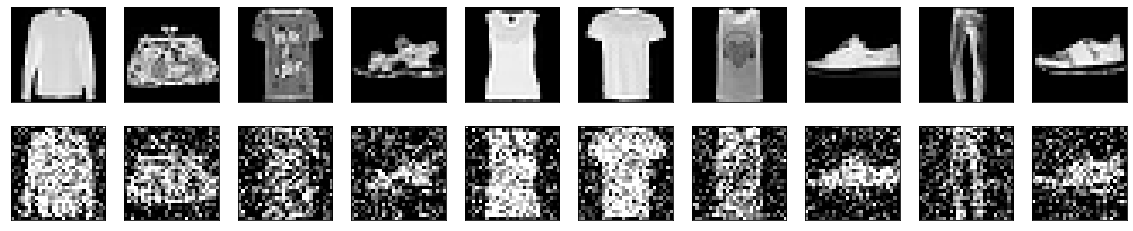

In [3]:
train_data = np.load("data/train_data.npy")
noisy_train_data = np.load("data/noisy_train_data.npy")

# Display the train data and a version of it with added noise
display(train_data, noisy_train_data)

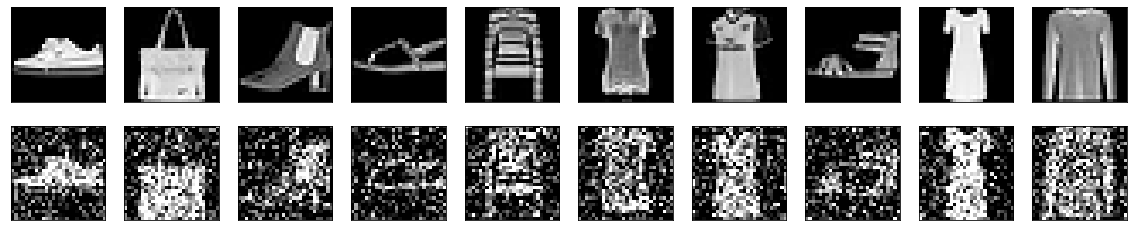

In [4]:
valid_data = np.load("data/valid_data.npy")
noisy_valid_data = np.load("data/noisy_valid_data.npy")

# Display the train data and a version of it with added noise
display(valid_data, noisy_valid_data)

## Build the autoencoder
* Try to tweak the hyperparameters - number of layers, activation function, etc.
* Make sure the model output layer is the same shape as the input layer - check summary

In [5]:
input = layers.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(8, (3, 3), activation="tanh", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(8, (3, 3), activation="tanh", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(8, (3, 3), strides=2, activation="tanh", padding="same")(x)
x = layers.Conv2DTranspose(8, (3, 3), strides=2, activation="tanh", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="tanh", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="sgd", loss="mae")
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 8)         80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         584       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 8)         584       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 8)         584   

2022-02-14 02:26:19.266228: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-02-14 02:26:19.266282: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: jupyter-pjavier
2022-02-14 02:26:19.266292: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: jupyter-pjavier
2022-02-14 02:26:19.266433: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 460.27.4
2022-02-14 02:26:19.266457: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 460.27.4
2022-02-14 02:26:19.266465: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 460.27.4
2022-02-14 02:26:19.266696: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU in

## Train the model

In [6]:
history = autoencoder.fit(
            x=noisy_train_data,
            y=train_data,
            epochs=2,
            batch_size=5000,
            shuffle=True,
            validation_data=(noisy_valid_data, valid_data),
            )

2022-02-14 02:26:19.670995: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/2
10/10 [==============================] - 7s 604ms/step - loss: 0.2938 - val_loss: 0.2895
Epoch 2/2
10/10 [==============================] - 6s 577ms/step - loss: 0.2881 - val_loss: 0.2881


## Show performance per epoch

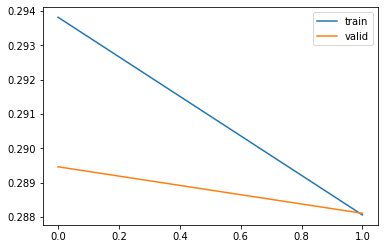

In [7]:
df_hist = pd.DataFrame.from_dict(history.history)
plt.plot(df_hist.index, df_hist.loss, label='train')
plt.plot(df_hist.index, df_hist.val_loss, label='valid')
plt.legend()

## Show predictions on validation set

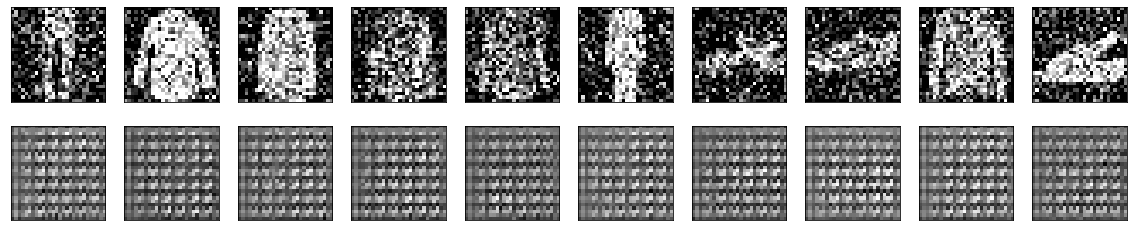

In [8]:
predictions = autoencoder.predict(noisy_valid_data)
display(noisy_valid_data, predictions)

## Predict on test set
**NOTE** - predict as is. Do not shuffle!

In [9]:
# load test set
noisy_test_data = np.load('data/noisy_test_data.npy')
noisy_test_data.shape

(5000, 28, 28, 1)

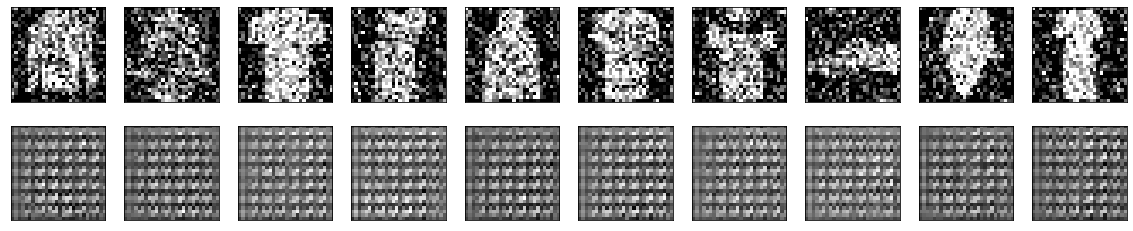

In [10]:
predictions = autoencoder.predict(noisy_test_data)
display(noisy_test_data, predictions)

## Reformat for submission

In [11]:
predictions.shape

(5000, 28, 28, 1)

In [12]:
df_preds = pd.DataFrame(predictions.flatten())
df_preds = df_preds.reset_index()
df_preds.columns=['Id', 'Predicted']
df_preds.head()

,Id,Predicted
0,0,0.012889
1,1,0.052373
2,2,0.028545
3,3,0.023337
4,4,0.012537


In [13]:
df_preds.shape

(3920000, 2)

In [14]:
df_preds.to_csv("df_preds.csv", index=False)